# Installs

In [1]:
!pip install pyathena

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 173.5 MB 61 kB/s               
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime
from pyathena import connect

In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [10]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

import boto3

OK


## Load Data

In [52]:
# Read from S3 - Enter filename for Key
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-w210-eth', Key='pipeline_df.csv')
data = pd.read_csv(obj['Body'])
data.head()

,number,lag_cutoff_60,latest_avail_60,latest_avail_time_60,latest_avail_time_dt_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12967000,1628193703,12966996,1628193692,2021-08-05 20:01:32,NaN,NaN,120526,29134367,29133470,1628193763,359,4.452760e+10,2021-08-05 20:02:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,200955.573816,4.452760e+10,7.651867e+10,21000.0,81151.727019,4.452760e+10,7.651867e+10,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12967001,1628193752,12966998,1628193741,2021-08-05 20:02:21,NaN,NaN,140900,29105917,29100379,1628193812,280,5.009321e+10,2021-08-05 20:03:32,NaN,NaN,0.169042,-0.000977,0.124992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,167389.685714,5.132502e+10,5.895961e+10,21000.0,103929.925000,5.132502e+10,5.895961e+10,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12967002,1628193758,12966999,1628193758,2021-08-05 20:02:38,NaN,NaN,30800,29077495,8090478,1628193818,110,5.635247e+10,2021-08-05 20:03:38,NaN,NaN,-0.781405,-0.000977,0.124952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,171688.036364,5.635247e+10,7.016925e+10,21000.0,73549.800000,5.635247e+10,7.016925e+10,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12967003,1628193776,12967000,1628193763,2021-08-05 20:02:43,NaN,NaN,115073,29049101,29028978,1628193836,355,5.322827e+10,2021-08-05 20:03:56,NaN,NaN,2.736136,-0.000976,-0.055440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,185849.473239,5.645752e+10,8.312962e+10,21000.0,81771.769014,5.645752e+10,8.312962e+10,355.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12967004,1628193851,12967003,1628193836,2021-08-05 20:03:56,NaN,NaN,135160,29077468,21130789,1628193911,278,5.987259e+10,2021-08-05 20:05:11,NaN,NaN,0.174559,0.000977,0.124827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,150822.420863,6.087259e+10,7.411313e+10,21000.0,76010.032374,6.087259e+10,7.411313e+10,278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [53]:
data.rename(columns={'number': 'block_number'}, inplace=True)

In [54]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,latest_avail_time_60,latest_avail_time_dt_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12967000,1628193703,12966996,1628193692,2021-08-05 20:01:32,NaN,NaN,120526,29134367,29133470,1628193763,359,4.452760e+10,2021-08-05 20:02:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,200955.573816,4.452760e+10,7.651867e+10,21000.0,81151.727019,4.452760e+10,7.651867e+10,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12967001,1628193752,12966998,1628193741,2021-08-05 20:02:21,NaN,NaN,140900,29105917,29100379,1628193812,280,5.009321e+10,2021-08-05 20:03:32,NaN,NaN,0.169042,-0.000977,0.124992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,167389.685714,5.132502e+10,5.895961e+10,21000.0,103929.925000,5.132502e+10,5.895961e+10,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12967002,1628193758,12966999,1628193758,2021-08-05 20:02:38,NaN,NaN,30800,29077495,8090478,1628193818,110,5.635247e+10,2021-08-05 20:03:38,NaN,NaN,-0.781405,-0.000977,0.124952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,171688.036364,5.635247e+10,7.016925e+10,21000.0,73549.800000,5.635247e+10,7.016925e+10,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12967003,1628193776,12967000,1628193763,2021-08-05 20:02:43,NaN,NaN,115073,29049101,29028978,1628193836,355,5.322827e+10,2021-08-05 20:03:56,NaN,NaN,2.736136,-0.000976,-0.055440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,185849.473239,5.645752e+10,8.312962e+10,21000.0,81771.769014,5.645752e+10,8.312962e+10,355.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12967004,1628193851,12967003,1628193836,2021-08-05 20:03:56,NaN,NaN,135160,29077468,21130789,1628193911,278,5.987259e+10,2021-08-05 20:05:11,NaN,NaN,0.174559,0.000977,0.124827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000.0,150822.420863,6.087259e+10,7.411313e+10,21000.0,76010.032374,6.087259e+10,7.411313e+10,278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [55]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60',
       'latest_avail_time_60', 'latest_avail_time_dt_60', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5'

In [56]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 12967000
median block number: 12967500.0
max block number: 12968000


In [25]:
# print("length of data before dropping NAs:", len(data))
# data = data.dropna()
# print("length of data after dropping NAs:", len(data))

length of data before dropping NAs: 1001
length of data after dropping NAs: 0


In [57]:
pd.options.display.max_columns = None
data.describe()

,block_number,lag_cutoff_60,latest_avail_60,latest_avail_time_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg,total_difficulty_pct_chg,size_pct_chg,gas_limit_pct_chg,base_fee_per_gas_pct_chg,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
count,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03,0.0,0.0,1001.000000,1.001000e+03,1.001000e+03,1.001000e+03,1001.000000,1.001000e+03,0.0,0.0,1000.000000,1000.000000,1000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,996.000000,976.000000,951.000000,901.000000,996.000000,976.000000,951.000000,901.000000,996.000000,976.000000,951.000000,901.000000,988.000000,9.880000e+02,9.880000e+02,9.880000e+02,988.000000,988.000000,9.880000e+02,9.880000e+02,988.000000,983.000000,963.000000,938.000000,888.000000,983.000000,963.000000,938.000000,888.000000,983.000000,963.000000,938.000000,888.000000,983.000000,963.000000,938.000000,888.000000,983.000000,963.000000,938.000000,888.000000
mean,1.296750e+07,1.628201e+09,1.296749e+07,1.628201e+09,NaN,NaN,74384.190809,2.984144e+07,1.536109e+07,1.628201e+09,174.716284,4.450553e+10,NaN,NaN,5.564839,0.000030,0.003761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.499322,3.346290,3.896573,3.798527,0.000152,0.000577,0.001234,0.002677,0.004189,-0.001346,-0.010576,-0.034183,21477.340081,1.807454e+05,4.607653e+10,6.101827e+10,21237.652834,89597.731641,4.607653e+10,6.101827e+10,177.015182,0.090629,0.109903,0.096862,0.102847,0.025479,0.021182,0.014852,0.002397,0.075881,0.075047,0.080644,0.082620,0.025479,0.021182,0.014852,0.002397,1.810718,1.732276,1.904469,1.855724
std,2.891081e+02,3.905558e+03,2.889922e+02,3.906175e+03,NaN,NaN,54235.581450,2.625489e+05,1.064436e+07,3.905558e+03,126.736543,7.839646e+09,NaN,NaN,26.952593,0.000872,0.089178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.804164,18.010285,20.516355,20.379808,0.001704,0.002732,0.003626,0.005631,0.108505,0.134797,0.166714,0.163200,10989.472327,7.506843e+04,8.240546e+09,1.323230e+10,6971.851353,24110.851191,8.240546e+09,1.323230e+10,125.961730,0.552962,1.106492,0.572733,0.559807,0.250502,0.256464,0.259449,0.260697,0.463892,0.442535,0.458329,0.452003,0.250502,0.256464,0.259449,0.260697,8.439131,8.513350,9.241101,8.122385
min,1.296700e+07,1.628194e+09,1.296700e+07,1.628194e+09,NaN,NaN,537.000000,2.904910e+07,0.000000e+00,1.628194e+09,0.000000,2.818995e+10,NaN,NaN,-0.997165,-0.000977,-0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.997427,-0.997369,-0.996485,-0.998040,-0.004873,-0.007791,-0.007791,-0.007

## Create train / dev / test splits

In [58]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60',
       'latest_avail_time_60', 'latest_avail_time_dt_60', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5'

### Set X & Y columns

In [59]:

X_columns = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

Y_column = ['effective_gas_price_mean']


In [61]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60',
       'latest_avail_time_60', 'latest_avail_time_dt_60', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5'

### Check validity of data

In [62]:
data[X_columns].describe()

,size_pct_chg_last_50_to_5,size_pct_chg_last_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_5
count,951.000000,996.000000,951.000000,996.000000,938.000000,983.000000,938.000000,983.000000,938.000000,983.000000
mean,3.896573,3.499322,-0.010576,0.004189,0.014852,0.025479,1.904469,1.810718,0.014852,0.025479
std,20.516355,18.804164,0.166714,0.108505,0.259449,0.250502,9.241101,8.439131,0.259449,0.250502
min,-0.996485,-0.997427,-0.414373,-0.295313,-0.694093,-0.701871,-0.993333,-0.987879,-0.694093,-0.701871
25%,-0.610338,-0.594687,-0.124856,-0.065943,-0.154970,-0.136510,-0.575898,-0.591663,-0.154970,-0.136510
50%,0.005043,-0.010453,-0.018242,-0.006893,-0.020377,-0.005597,-0.011542,0.030418,-0.020377,-0.005597
75%,1.560455,1.396136,0.082902,0.065039,0.146624,0.137265,1.407554,1.444949,0.146624,0.137265
max,303.561243,291.357798,0.612722,0.502709,1.521896,2.122559,151.666667,164.500000,1.521896,2.122559


In [63]:
print("Percent NA's")
data[X_columns].isna().sum()/data[X_columns].count()

Percent NA's


size_pct_chg_last_50_to_5                            0.052576
size_pct_chg_last_5                                  0.005020
base_fee_per_gas_pct_chg_last_50_to_5                0.052576
base_fee_per_gas_pct_chg_last_5                      0.005020
gas_price_mean_pct_chg_last_50_to_5                  0.067164
gas_price_mean_pct_chg_last_5                        0.018311
number_transactions_in_block_pct_chg_last_50_to_5    0.067164
number_transactions_in_block_pct_chg_last_5          0.018311
effective_gas_price_mean_pct_chg_last_50_to_5        0.067164
effective_gas_price_mean_pct_chg_last_5              0.018311
dtype: float64

In [64]:
data[X_columns].dropna().shape

(938, 10)

In [68]:
data_original = data.copy()
data = data[X_columns+Y_column+['block_number']].dropna()

### Create the data sets

In [69]:
# X_train = data[data.timestamp<'10/01/2021'][X_columns]
# Y_train = data[data.timestamp<'10/01/2021'][Y_column]

# X_dev = data[(data.timestamp>='10/01/2021') & (data.timestamp<='11/01/2021')][X_columns]
# Y_dev = data[(data.timestamp>='10/01/2021') & (data.timestamp<='11/01/2021')][Y_column]

# X_test = data[data.timestamp>'11/01/2021'][X_columns]
# Y_test = data[data.timestamp>'11/01/2021'][Y_column]

X_train = data[data.block_number<12967800][X_columns]
Y_train = data[data.block_number<12967800][Y_column]

X_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][X_columns]
Y_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][Y_column]

X_test = data[data.block_number>13141000][X_columns]
Y_test = data[data.block_number>13141000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

## Linear Regression

In [74]:
# Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)

lin_reg_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']


# fit train and test data. 
lin_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred = lin_reg.predict(X_train[lin_reg_features])

# Get training metrics
lr_mse_train = mean_squared_error(Y_train, y_train_pred)
lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Linear Regression model on train data is: %.4f'%lr_mse_train)
print ('The RMSE of the Linear Regression model on train data is: %.4f'%lr_rmse_train)
print ('The R^2 of the Linear Regression model on train data is: %.4f'%lr_r2score_train)

# Predict dev data. 
y_dev_pred_lr = lin_reg.predict(X_dev[lin_reg_features])

lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)

print ('The MSE of the Linear Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Linear Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Linear Regression model on dev data is: %.4f'%lr_r2score_dev)

lin_reg.coef_

The MSE of the Linear Regression model on train data is: 77354564574072504320.0000
The RMSE of the Linear Regression model on train data is: 8795144374.8282
The R^2 of the Linear Regression model on train data is: 0.4619
The MSE of the Linear Regression model on dev data is: 90960151877599838208.0000
The RMSE of the Linear Regression model on dev data is: 9537303176.3492
The R^2 of the Linear Regression model on dev data is: 0.6150


array([[-4.52525817e+07, -3.58792629e+07,  4.90439495e+08,
         2.55324599e+09,  9.29480216e+09,  1.96413272e+10,
         5.12032243e+07,  3.85198661e+07,  9.29480216e+09,
         1.96413272e+10]])

In [75]:
import statsmodels.api as sm
mod = sm.OLS(Y_train,X_train[lin_reg_features])
mod2 = mod.fit()
print(mod2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     effective_gas_price_mean   R-squared (uncentered):                   0.166
Model:                                  OLS   Adj. R-squared (uncentered):              0.156
Method:                       Least Squares   F-statistic:                              18.18
Date:                      Sun, 31 Oct 2021   Prob (F-statistic):                    6.15e-25
Time:                              15:27:46   Log-Likelihood:                         -19405.
No. Observations:                       741   AIC:                                  3.883e+04
Df Residuals:                           733   BIC:                                  3.886e+04
Df Model:                                 8                                                  
Covariance Type:                  nonrobust                                                  
                                                        coef

## Ridge Regression

In [77]:
#Instantiate regression
ridge_reg = Ridge(alpha=0.75, random_state=42)

# fit train and test data. 
ridge_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

# Get training metrics
rr_mse_train = mean_squared_error(Y_train, y_train_pred)
rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Ridge Regression model on train data is: %.4f'%rr_mse_train)
print ('The RMSE of the Ridge Regression model on train data is: %.4f'%rr_rmse_train)
print ('The R^2 of the Ridge Regression model on train data is: %.4f'%rr_r2score_train)

# Predict dev data. 
y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)

print ('The MSE of the Ridge Regression model on dev data is: %.4f'%rr_mse_dev)
print ('The RMSE of the Ridge Regression model on dev data is: %.4f'%rr_rmse_dev)
print ('The R^2 of the Ridge Regression model on dev data is: %.4f'%rr_r2score_dev)

print("coefficients:", ridge_reg.coef_)

The MSE of the Ridge Regression model on train data is: 77354564574072504320.0000
The RMSE of the Ridge Regression model on train data is: 8795144374.8282
The R^2 of the Ridge Regression model on train data is: 0.4619
The MSE of the Ridge Regression model on dev data is: 91432834909358817280.0000
The RMSE of the Ridge Regression model on dev data is: 9562051814.8229
The R^2 of the Ridge Regression model on dev data is: 0.6130
coefficients: [[-4.50137845e+07 -3.58640982e+07  7.18746231e+08  2.89600897e+09
   9.04384284e+09  1.93080519e+10  5.03399385e+07  3.75838148e+07
   9.04384284e+09  1.93080519e+10]]


## Random Forest

In [78]:
#Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 3, bootstrap = True, max_features = 4, 
                           min_samples_leaf = 50, random_state = 42)

rf_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

#Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

#Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

#Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
print(rf_MSE_train)
print(rf_MSE_dev)

8.863492569194555e+19
1.9544039541234637e+20


                                            Features  Feature_Importance
9            effective_gas_price_mean_pct_chg_last_5            0.376218
5                      gas_price_mean_pct_chg_last_5            0.371368
3                    base_fee_per_gas_pct_chg_last_5            0.081198
4                gas_price_mean_pct_chg_last_50_to_5            0.059393
8      effective_gas_price_mean_pct_chg_last_50_to_5            0.056085
1                                size_pct_chg_last_5            0.023913
2              base_fee_per_gas_pct_chg_last_50_to_5            0.015254
7        number_transactions_in_block_pct_chg_last_5            0.010442
0                          size_pct_chg_last_50_to_5            0.003332
6  number_transactions_in_block_pct_chg_last_50_to_5            0.002798


<AxesSubplot:title={'center':'Random Forest Feature Importance'}, ylabel='Features'>

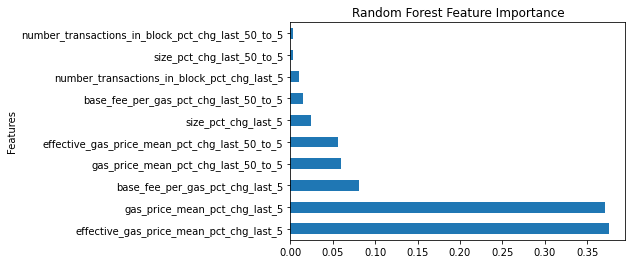

In [79]:
rf_feature_importances = rf.feature_importances_
rf_feature_importances_dict = {'Features': rf_features,
                               'Feature_Importance': rf_feature_importances}
rf_feature_importances_df = pd.DataFrame(rf_feature_importances_dict)
rf_feature_importances_df.sort_values(by=['Feature_Importance'], 
                                      ascending=False,
                                      inplace=True)
print(rf_feature_importances_df.head(30))

rf_feature_importances_df = rf_feature_importances_df.set_index('Features')
rf_feature_importances_df['Feature_Importance'].nlargest(15).plot(kind='barh',
                                                                  title='Random Forest Feature Importance')

In [ ]:
data.columns

## Gradient Boosting

In [80]:
xgb_features = ['size_pct_chg_last_50_to_5', 'size_pct_chg_last_5', 
             'base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

#set up the training matrix
dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
xgb_dict = {
        'booster': 'dart',
        #'booster': 'gbtree',
        #'booster': 'gblinear',
        'max_depth': 3,
        'random_state': 42,
        'learning_rate': 0.01,
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'sample_type': 'uniform',
        'subsample': 0.6,
        'normalize_type': 'tree',
        'rate_drop': 0.0,
        #'rate_drop': 0.2,
        'skip_drop': 0.2,
        'min_child_weight': 5,
        
    }
#starting hyperparameter of training rounds
training_rounds = 500

#train the model
bst = xgb.train(
    xgb_dict,
    dtrain,
    training_rounds,
    evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
    early_stopping_rounds=10) 


training_rounds = bst.best_ntree_limit
 
#get training predictions and MSE
xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)

#print("XGB train mean squared error:", xgb_train_mse)
print("XGB train root mean squared error:", xgb_train_rmse)

#get dev predictions and MSE
xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
xgb_dev_rmse = np.sqrt(xgb_dev_mse)

#print("XGB dev mean squared error:", xgb_dev_mse)
print("XGB dev root mean squared error:", xgb_dev_rmse)

[0]	RMSE-rmse:57692692480.00000
[1]	RMSE-rmse:57098555392.00000
[2]	RMSE-rmse:56518754304.00000
[3]	RMSE-rmse:55946043392.00000
[4]	RMSE-rmse:55379259392.00000
[5]	RMSE-rmse:54816989184.00000
[6]	RMSE-rmse:54260830208.00000
[7]	RMSE-rmse:53705420800.00000
[8]	RMSE-rmse:53163278336.00000
[9]	RMSE-rmse:52621225984.00000
[10]	RMSE-rmse:52084031488.00000
[11]	RMSE-rmse:51566567424.00000
[12]	RMSE-rmse:51042791424.00000
[13]	RMSE-rmse:50521210880.00000
[14]	RMSE-rmse:50007351296.00000
[15]	RMSE-rmse:49508904960.00000
[16]	RMSE-rmse:49004576768.00000
[17]	RMSE-rmse:48508727296.00000
[18]	RMSE-rmse:48011071488.00000
[19]	RMSE-rmse:47532584960.00000
[20]	RMSE-rmse:47049490432.00000
[21]	RMSE-rmse:46571614208.00000
[22]	RMSE-rmse:46093537280.00000
[23]	RMSE-rmse:45620756480.00000
[24]	RMSE-rmse:45157019648.00000
[25]	RMSE-rmse:44686999552.00000
[26]	RMSE-rmse:44240506880.00000
[27]	RMSE-rmse:43792171008.00000
[28]	RMSE-rmse:43355365376.00000
[29]	RMSE-rmse:42917834752.00000
[30]	RMSE-rmse:42478

In [81]:
#feature importance
xgb_importance_weight = bst.get_score(importance_type='weight')
xgb_importance_gain = bst.get_score(importance_type='gain')
xgb_importance_weight_df = pd.DataFrame.from_dict(xgb_importance_weight,
                                                  orient='index',
                                                  columns=['weight'])
xgb_importance_gain_df = pd.DataFrame.from_dict(xgb_importance_gain,
                                                  orient='index',
                                                  columns=['gain'])
xgb_feature_importance_df = xgb_importance_weight_df.join(xgb_importance_gain_df)
xgb_feature_importance_df.sort_values(by=['weight'], ascending=False, inplace=True)                 
print(xgb_feature_importance_df.head(30))


                                                   weight          gain
gas_price_mean_pct_chg_last_5                       550.0  1.669368e+21
gas_price_mean_pct_chg_last_50_to_5                 390.0  5.449063e+20
base_fee_per_gas_pct_chg_last_5                     116.0  4.200625e+20
size_pct_chg_last_50_to_5                            98.0  3.720866e+20
size_pct_chg_last_5                                  94.0  4.222335e+20
base_fee_per_gas_pct_chg_last_50_to_5                90.0  3.741898e+20
number_transactions_in_block_pct_chg_last_50_to_5    60.0  3.500055e+20
number_transactions_in_block_pct_chg_last_5          49.0  3.392946e+20


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

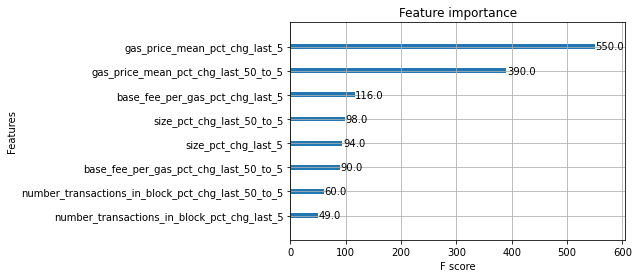

In [82]:
plot_importance(bst, max_num_features=30)

## Ensemble

In [83]:
ensemble_train_preds = (y_train_pred.ravel() + y_train_pred_rr.ravel() + rf_train_predictions + xgb_train_pred) / 4
print("train_rmse =", np.sqrt(mean_squared_error(ensemble_train_preds, Y_train)))


train_rmse = 8722931769.891417


In [84]:
len(y_train_pred)

741

In [85]:
len(xgb_train_pred)

741

In [87]:
a = 1